In [1]:
import numpy as np
from brainiak.reconstruct import iem as IEM
import matplotlib.pyplot as plt
import scipy.io

In this example, we will assume that the stimuli are circular checkerboards presented in 2-dimensional visual space. We will build an encoding model that has a grid of 6x6 channels, or basis functions, which also span this 2D space.

Read the documentation for the module to get further details on the IEM.

### About the data
The data and content of this notebook are adapted from the IEM tutorial written by Thomas Sprague & John Serences for MATLAB (https://github.com/tommysprague/IEM-tutorial).

"Participants viewed peripheral flickering checkerboard stimuli presented at a range of contrasts (0-70%, logarithmically spaced) while performing either a demanding target detection task (contrast change) at the stimulus position ("attend stimulus" condition) or at the fixation point ("attend fixation" condition). The stimuli appeared randomly on the left or right side of the screen. Targets appeared rarely, and trials in which targets do appear are not included in analyses. Thus, sensory conditions are perfectly equated across the attend stimulus and the attend fixation conditions.

In addition to this main attention task, paricipants also performed a "spatial mapping" task in which they viewed small checkerboard discs presented at different positions on the screen while they performed a demanding fixation task (contrast change detection)."

These data were collected by Thomas Sprague & Sirawaj Itthipuripat, for the following paper:
Itthipuripat, S., Sprague, T.,C., Serences, J.T. 2019. Functional MRI and EEG Index Complementary Attentional Modulations. J. Neurosci. 31:6162-6179. Data available at https://osf.io/savfp/.

In [2]:
# Load the fMRI data
data = scipy.io.loadmat('AL61_Bilat-V1_attnContrast.mat')
trn_conds = data['trn_conds']  # position in space for 128 trials
# flip to cartesian coordinates to make life easier
trn_conds[:,1] = trn_conds[:,1]*-1
trn = data['trn']  # matrix of (trials, voxels)

The test data have different conditions than the training data. There are four independent variables in these data based on the values in the following columns: 
- In column 1, whether the stimulus was on the left (1) or right (2) side of the screen. 
- In column 2, the logarithmically spaced stimulus contrast from lowest (1) to highest (6). 
- In column 3, the task instruction to attend to fixation (1) or the stimulus (2).
- In column 4, whether the target was present (1) or not (0).

In [3]:
# Note there are several different conditions in the test data.
tst_conds = data['tst_conds']
tst = data['tst']
attn_conds = np.unique(tst_conds[:, 2])
stim_contrasts = np.unique(tst_conds[:, 1])

[1 2] [1 2 3 4 5 6]


In [6]:
# Set up parameters
n_channels = [9, 5]  # channels in the x, y directions
cos_exponent = 5
stimx, stimy = [-17/2, 17/2], [-5, 5]
stim_res = [171, 101]
npixels = stim_res[0] * stim_res[1]
stim_size = 1.449
chanx, chany = [-6, 6], [-3, 3]

In [7]:
iem_obj = iem.InvertedEncoding2D(stim_xlim=stimx, stim_ylim=stimy,
                                 stimulus_resolution=stim_res,
                                 stim_radius=stim_size,
                                 chan_xlim=chanx, chan_ylim=chany,
                                 channel_exp=7)

The quality and interpretability of your stimulus reconstructions all depend on how you set up the channels, or basis functions, in the model. In order to ensure that you can accurately reconstruct stimuli at all portions in the area where you have presented stimuli, you will want to evenly space your basis functions in that region. You also will likely want to ensure some overlap between the basis functions.

There are two pre-built functions to create a 2D grid of basis functions, to use a rectangular grid or a triangular grid. A triangular grid is more space-efficient, so let's use that.

Note you will need to define these basis functions before you can fit the model. Otherwise it will throw an error.

In [46]:
basis_fcns, basis_centers = iem_obj.define_basis_functions_sqgrid(n_channels)

To visualize these, you will need to reshape the second dimension into the 2D pixel space where the stimuli are represented.

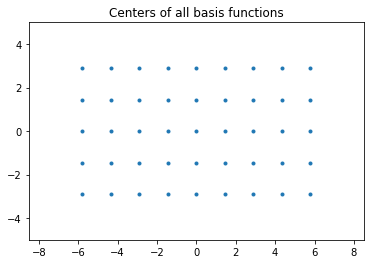

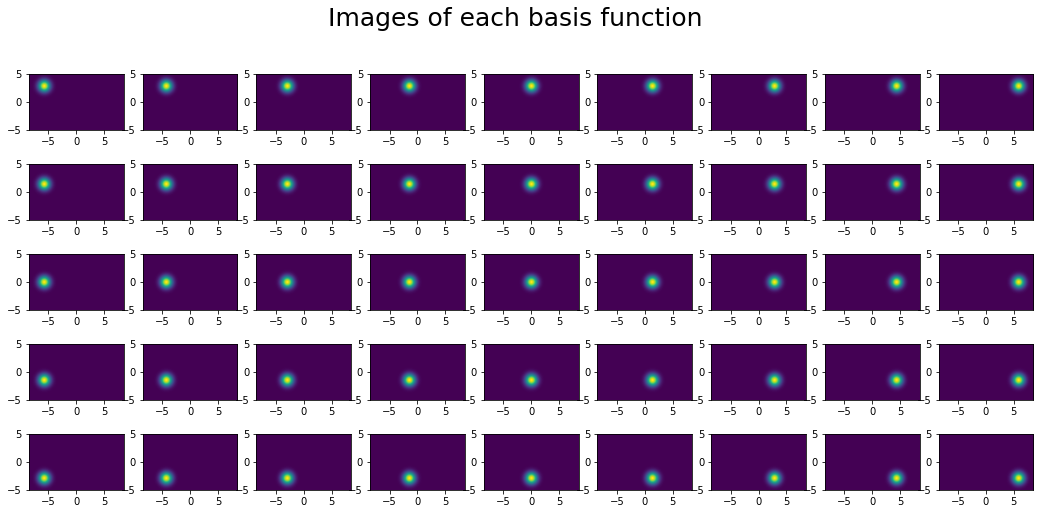

In [71]:
plt.plot(basis_centers[:, 0], basis_centers[:, 1], '.')
plt.title('Centers of all basis functions')
plt.xlim(stimx)
plt.ylim(stimy)
plt.show()

f, ax = plt.subplots(n_channels[1], n_channels[0], figsize=[18, 8])
i = 0
for ii in range(n_channels[1]):
    for jj in range(n_channels[0]):
        ax[ii, jj].imshow(basis_fcns[i, :].reshape(stim_res[1], 
                                                   stim_res[0]),
                          extent=[stimx[0], stimx[1], stimy[0], stimy[1]])
        i += 1
plt.suptitle('Images of each basis function', fontsize=25)
plt.show()

To check how well the basis functions cover the stimulus domain, we can sum across all the basis functions.

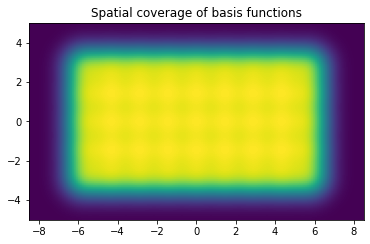

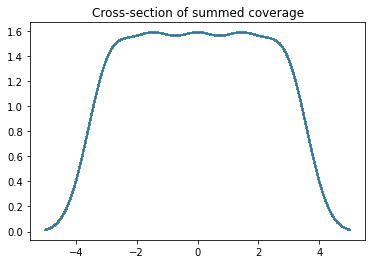

In [77]:
sum_fcns = basis_fcns.sum(axis=0).reshape(stim_res[1], stim_res[0])
plt.imshow(sum_fcns, extent=[stimx[0], stimx[1], stimy[0], stimy[1]])
plt.title('Spatial coverage of basis functions')

plt.figure()
plt.plot(iem_obj.yp, sum_fcns[:, 51])
plt.title('Cross-section of summed coverage')
plt.show()

Next, we want to map channel responses for each voxel. To do this, we fit a standard general linear model (GLM), where the design matrix is the channel activations for each trial. Below, you can see the design matrix of these trial activations in the channel domain (x-axis: trials, y-axis: channels, color: activations).

(128, 45)


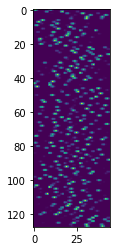

In [78]:
C = iem_obj._define_trial_activations(trn_conds)
plt.imshow(C)
print(C.shape)

Whenever you run the fit() function, the trial-wise channel activations will be created automatically, and the GLM will be fit on the training data and feature labels. Using this, we can then predict the feature responses on a set of test data.

In [79]:
iem_obj = iem_obj.fit(trn, trn_conds)
stim_reconstructions = iem_obj.predict_feature_responses(tst)

## Average feature reconstructions across trials

In this experiment, we are not specifically interested in separating trials by whether stimuli were on the left or the right. Instead, we're interested in how the activation in the model-based reconstruction varies with the experimental manipulation of contrast and attended location. For the sake of visualization and quantification, we can simply average across the trials of interest. Below we separated the trials by contrast and attention location, but averaged across trials where the stimulus appeared on the left side of the screen and the target was not present (to ensure that overall contrast is identical across averaged trials).

In [51]:
vmin, vmax = 0, 0
mean_recons = np.zeros((stim_contrasts.size, attn_conds.size, npixels))

for aa, attn_cond in enumerate(attn_conds):
    for ss, contrast in enumerate(stim_contrasts):
        thisidx = np.argwhere((tst_conds[:, 0] == 1) &
                              (tst_conds[:, 1] == contrast) &
                              (tst_conds[:, 2] == attn_cond) &
                              (tst_conds[:, 3] == 0))
        rs = np.mean(stim_reconstructions[:, thisidx], axis=1)
        if rs.min() < vmin:
            vmin = rs.min()
        if rs.max() > vmax:
            vmax = rs.max()
        mean_recons[ss, aa, :] = rs.squeeze()

Finally, we plot the data as a function of:
 
1) whether subjects were attending to the stimulus or fixation, and
2) the contrast of the stimulus (across six levels).

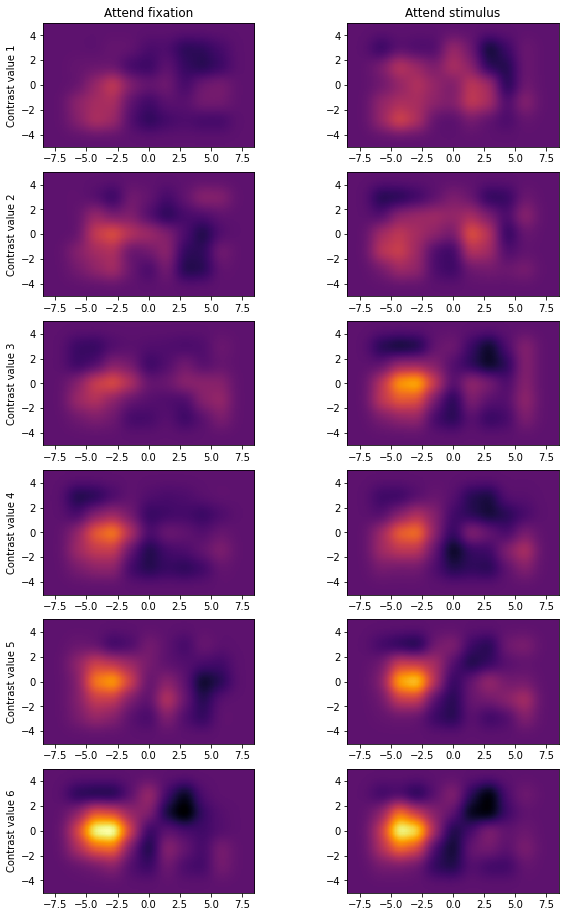

In [52]:
f, ax = plt.subplots(6, 2, figsize=(10,16))
for aa, attn_cond in enumerate(attn_conds):
    for ss, contrast in enumerate(stim_contrasts):
        ax[ss, aa].imshow(mean_recons[ss, aa, :].\
                          reshape(stim_res[1], stim_res[0]),
                          origin='lower', interpolation='none',
                          cmap='inferno',
                          extent=[stimx[0], stimx[1], stimy[0], stimy[1]],
                          vmin=vmin, vmax=vmax)
        if contrast == stim_contrasts[0]:
            if attn_cond == 1:
                ax[ss, aa].set_title('Attend fixation')
            elif attn_cond == 2:
                ax[ss, aa].set_title('Attend stimulus')
        if attn_cond == 1:
            ax[ss, aa].set_ylabel('Contrast value {}'.format(contrast))

These data suggest that increasing the contrast leads to stronger activation of the stimulus. They also suggest that the effect of attention is greatest at low contrast levels -- e.g. at contrast level 3, we see a clear enhancement when the participant is attending to the stimulus compared to when they are attending fixation.

However, since this is single-participant data, these effects should be quantified across a group of subjects.

Full results from these manipulations across a group of subjects can be seen in Itthipuripat, Sprague, Serences 2019.